# hmm models

Currently have two models with these common parameters to calculate transition matrix 

`chromosome_size`
: Chromosome size in Mb

`num_markers`
: Number of markers given for a given chromosome size

`recomb_rate`
: Recombination rate in cM/Mb. default: 3.3

`n_iter`
: Number of iterations for converging a model

### 1. Identify homozygous regions 

Hidden states -- Homozygous or Heterozygous

Observed states -- Genotyped SNPs either 00/11 (homozygous, state 0), heterozygous (state 1) and NA (state 2). Parameters used for estimating emmission probability matrix:


`sample_depth`
: Average coverage for each genotyped SNP. Default of 1.5


`fraction_homo_parents`
: Fraction of sites in parental genomes which are heterozygous. Default of 0.99

`avg_sites_segregating`
: Expected pi measure between parents. Fraction of provided sites which are segregating between parents. Default: 0.01

`base_error`
: expected genotyping error in the sample. default: 0.001

        
### 2. Recombination break points -- hidden states as AA, AB and BB

Adapted the model from Andolfatto *et al.*. Parameters required for estimating emission matrix

`snps_p1`: SNPs genotyped for parent 1

`snps_p2`: SNPs genotyped for parent 2

`base_error`: Genotyping error in the sample

`sample_depth`: Average coverage on the SNPs

In [2]:
import numpy as np
import numpy.ma 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from snpmatch.core import parsers, genomes, genotype_cross, snp_genotype, infer, results
import logging
log = logging.getLogger(__name__)
import os.path
import json

genome = genomes.Genome("athaliana_tair10")


db_file = "/groups/nordborg/projects/field_experiments/007.pilot.sequencing/018.genotyping.by.plate/996.Swedes.220_6.newReSeq.July2020/002.mergeVCF/02_Swedes200_6.newReSeq_2.3M.BIALLELIC.hdf5"
parents = "6046x6191_reSeq"
geno_cross = genotype_cross.GenotypeCross(snp_genotype.load_genotype_files( db_file ), parents )

### input files

You could provide input either by a SNP matrix or even a VCF file

In [2]:
# input hdf5 file -- makedb on the VCF file
# input_snps_file = "/groups/nordborg/projects/epiclines/005.manu.crosses.2020/004.design_resolved/snps_bcftools/f2_batchthree.maf_filtered.hdf5"
# input_snps = snp_genotype.load_genotype_files( input_snps_file )
# segregating_ix = geno_cross.g.get_common_positions( geno_cross.commonSNPsCHR, geno_cross.commonSNPsPOS, np.array(input_snps.g.chromosomes), input_snps.g.positions)


## input vcf file for the samples
input_vcf_file = "/groups/nordborg/projects/epiclines/005.manu.crosses.2020/004.design_resolved/snps_bcftools/f2_26052021.maf_filtered.vcf" 
snpvcf = parsers.import_vcf_file(inFile =  input_vcf_file , logDebug = False, samples_to_load = None, add_fields=['calldata/DP'])
samples_ids = pd.Series(snpvcf['samples']) 
samples_gt = snpvcf['gt']
samples_gt = pd.DataFrame(samples_gt.astype(str))
segregating_ix = geno_cross.g.get_common_positions( geno_cross.commonSNPsCHR, geno_cross.commonSNPsPOS, snpvcf['chr'], snpvcf['pos'] )

In [51]:
# # sample_ix = np.where(samples_ids.str.contains('P_6046'))[0]   ## ancestral state 0
# sample_ix = np.where(samples_ids.str.contains('P_6191'))[0]  ## ancestral state 1
# # sample_ix = np.where(samples_ids.str.contains('F1'))[0]  #### Het


# t_genotypes_raw = pd.Series(allSNPGenos_raw.iloc[:,sample_ix].values.flatten())
# t_genotypes_raw.value_counts( normalize = True, sort = False )

In [179]:
np.where( snpvcf['samples'] == "T4_P2.C11_F2_D1" )

(array([394]),)

In [64]:
t_chr_ix = 0
sample_ix = 394
ec = np.unique(snpvcf['chr'])[t_chr_ix] 
eclen = genome.chrlen[t_chr_ix]
reqChrind = np.where( snpvcf['chr'][segregating_ix[1]] == ec)[0]

t_sample_snps = parsers.parseGT(samples_gt.iloc[:,sample_ix][segregating_ix[1][reqChrind]].values)
# input_snps.g_acc.snps[:,sample_ix][segregating_ix[1][reqChrind]]
t_snps_p1 = geno_cross.snpsP1[segregating_ix[0][reqChrind]]
t_snps_p2 = geno_cross.snpsP2[segregating_ix[0][reqChrind]]

# t_depth = 1.5
t_depth = snpvcf['calldata/DP'][:,sample_ix][segregating_ix[1][reqChrind]]
t_base_error = 0.03

t_model = infer.IdentifyAncestryF2individual(chromosome_size= eclen/1000000, snps_p1 = t_snps_p1, snps_p2 = t_snps_p2, recomb_rate=3.5, base_error = t_base_error, sample_depth= t_depth, error_p1 = 0.0001, error_p2 = 0.0001)
t_model.geno_raw = infer.polarize_snps(t_sample_snps, t_snps_p1, t_snps_p2 )
t_model.output = t_model.viterbi( t_sample_snps )

t_homo_model = infer.IdentifyStrechesofHeterozygosity(chromosome_size= eclen/1000000, num_markers = t_sample_snps.shape[0], avg_sites_segregating=0.8, sample_depth=t_depth, fraction_homo_parents = 0.99, base_error=t_base_error, recomb_rate=3.5)
t_homo_model.geno_raw = t_homo_model.snp_to_observations( t_sample_snps )
t_homo_model.out_geno = t_homo_model.viterbi( t_sample_snps )

# # # uniq_neighbor( t_genotypes[1] )
# print( "%s" % t_model.output[0] )
# sns.heatmap( model.model.predict_proba(t_genotypes_raw.reshape((-1, 1))).T, cmap = "Reds" )

In [28]:
pd.DataFrame(t_homo_model.calc_emissions( 0.03, sample_depth=np.array([0]), fraction_homo_parents=0.99, avg_sites_segregating=0.8 )[:,:,0])

,0,1,2
0,1.0,1.0,1.0
1,1.0,1.0,1.0


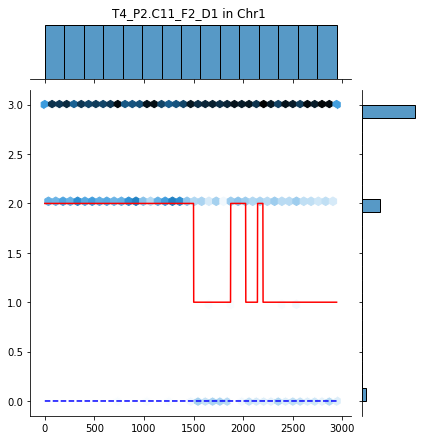

In [65]:
p = sns.jointplot(x = np.arange(t_model.geno_raw.shape[0]), y =  t_model.geno_raw, kind="hex", joint_kws=dict(gridsize=40))
# p = sns.jointplot(x = np.arange(t_model.geno_raw.shape[0]), y = t_sample_snps, kind="hex", joint_kws=dict(gridsize=40))
p.ax_joint.plot(np.arange(t_model.geno_raw.shape[0]), t_model.output[0], 'r-')
p.ax_joint.plot(np.arange(t_homo_model.out_geno[0].shape[0]), t_homo_model.out_geno[0], 'b--' )

# p.ax_joint.plot(np.arange(t_homo_model.out_geno[1].shape[0]), myown[0], 'g-.' )

# p.ax_marg_x.set_title( "%s in %s " % (input_snps.accessions[sample_ix], ec) )
p.ax_marg_x.set_title( "%s in %s " % (snpvcf['samples'][sample_ix], ec) )

plt.show()

## Mapped to pacbio 6046

In [671]:
snpvcf_pcbio = parsers.import_vcf_file(inFile =  "/groups/nordborg/projects/epiclines/005.manu.crosses.2020/006.mapping_to_pacbio/003.mapped_to_6046/snps_bcftools/f2_mapped6046.maf_filtered.vcf.gz" , logDebug = False, samples_to_load = None, add_fields=['calldata/DP'])

In [3]:
snpvcf_pcbio = parsers.import_vcf_file(inFile =  "/groups/nordborg/projects/epiclines/005.manu.crosses.2020/006.mapping_to_pacbio/003.mapped_to_6046/snps_bcftools/variants_bcftools/T16_P1.A12_F2_D1.snps.vcf.gz" , logDebug = False, samples_to_load = None, add_fields=['calldata/DP'])

In [433]:
np.where(pd.Series(snpvcf_pcbio['samples']).str.contains("P_6191"))

(array([ 35,  65,  93, 114, 124, 264, 312, 343, 355, 365, 370, 374, 395,
        405, 521, 529, 550]),)

In [6]:
snpvcf_pcbio['chr']

array(['6046_Chr1', '6046_Chr1', '6046_Chr1', ..., '6046_ChrM',
       '6046_ChrM', '6046_ChrM'], dtype='<U9')

In [7]:
t_chr_ix = 1
sample_ix = 0 ### 40, 57 is interesting for chr2

t_avg_seg = {0: 0.95, 1: 0.9, 2: 0.98, 3: 0.98, 4: 0.98 }  ##
t_p_error = {0: 0.001, 1: 0.0097, 2: 0.0097, 3: 0.0097, 4: 0.0097 }
t_base_error = 0.03

ec = np.unique(snpvcf_pcbio['chr'])[t_chr_ix] 
eclen = genome.chrlen[t_chr_ix]
reqChrind_pcbio = np.where( snpvcf_pcbio['chr'] == ec )[0]

t_sample_snps =  parsers.parseGT( snpvcf_pcbio['gt'][:, sample_ix][reqChrind_pcbio] )
t_depth = snpvcf_pcbio['calldata/DP'][:,sample_ix][reqChrind_pcbio]


# # t_model_pc = infer.IdentifyAncestryF2individual(chromosome_size= eclen/1000000, snps_p1 = t_snps_p1, snps_p2 = t_snps_p2, recomb_rate=3.5, base_error = t_base_error, sample_depth= t_depth, error_p1 = 0.00001, error_p2 = 0.01)
t_model_pc = infer.IdentifyAncestryF2_RefvsnonRef(chromosome_size= eclen/1000000, num_markers = t_sample_snps.shape[0], recomb_rate=3.5, base_error = t_base_error, sample_depth= t_depth, avg_sites_segregating=t_avg_seg[t_chr_ix], fraction_homo_parents=0.975, error_p1 = t_p_error[t_chr_ix], error_p2 = t_p_error[t_chr_ix])
t_model_pc.geno_raw = t_model_pc.snp_to_observations( t_sample_snps )
# t_model_pc.output = t_model_pc.viterbi( t_sample_snps )

# p = sns.jointplot(x = np.arange(t_model_pc.geno_raw.shape[0]), y =  t_model_pc.geno_raw, kind="hex", joint_kws=dict(gridsize=40))
# p.ax_joint.plot(np.arange(t_model_pc.geno_raw.shape[0]), t_model_pc.output[0], 'r-')
# # p.ax_marg_x.set_title( "%s in %s " % (input_snps.accessions[sample_ix], ec) )
# p.ax_marg_x.set_title( "%s in %s " % (snpvcf_pcbio['samples'][sample_ix], ec) )

# plt.show()

In [9]:
t_sample_snps.shape

(3264583,)

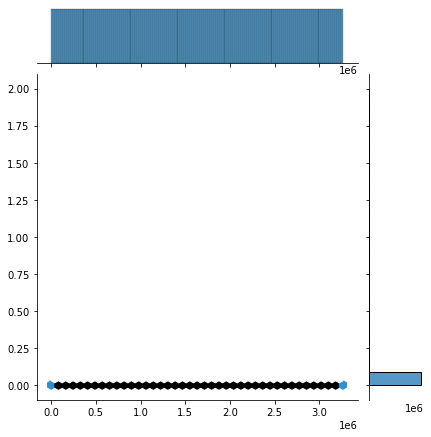

In [14]:
p = sns.jointplot(x = np.arange(t_model_pc.geno_raw.shape[0]), y =  t_model_pc.geno_raw, kind="hex", joint_kws=dict(gridsize=40))
# p.ax_joint.plot(np.arange(t_model_pc.geno_raw.shape[0]), t_model_pc.output[0], 'r-')
# # p.ax_marg_x.set_title( "%s in %s " % (input_snps.accessions[sample_ix], ec) )
# p.ax_marg_x.set_title( "%s in %s " % (snpvcf_pcbio['samples'][sample_ix], ec) )

plt.show()

In [668]:
t_ix = 77
print(t_depth[t_ix])
print( t_model_pc.geno_raw[t_ix] )
pd.DataFrame(t_model_pc.emission_prob[:,:,t_ix], index = t_model_pc.ancestry, columns=t_model_pc.observed_states)


1
0


,00,01,11,NA
AA,0.949360,2.655511e-17,0.050640,1.0
AB,0.546088,3.202146e-18,0.453912,1.0
BB,0.141629,2.192529e-17,0.858371,1.0


In [99]:
pd.DataFrame(t_homo_model_pc.emission_prob[:,:,t_ix], index=t_homo_model_pc.hidden_states, columns=t_homo_model_pc.observed_states)

,00||11,01,NA
HOMO,1.0,0.0,1.0
HET,1.0,0.0,1.0
